In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [26]:
data = pd.read_csv('road_accident.csv')

In [27]:
data.columns

Index(['Date', 'Time', 'Day_of_Week', 'Barangay', 'Latitude', 'Longitude',
       'Weather', 'Road_Condition', 'Vehicle_Type', 'Driver_Age',
       'Driver_Gender', 'Accident_Type', 'Injuries', 'Fatalities'],
      dtype='object')

In [28]:
data.shape

(1500, 14)

In [29]:
X = data.drop('Accident_Type', axis=1)
y = data['Accident_Type']

In [30]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [31]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [32]:
# Create pipeline with preprocessor and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:


# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Fit the model with encoded target variable
model.fit(X_train, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:05:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'Driver_Age', 'Injuries', 'Fatalities'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [35]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


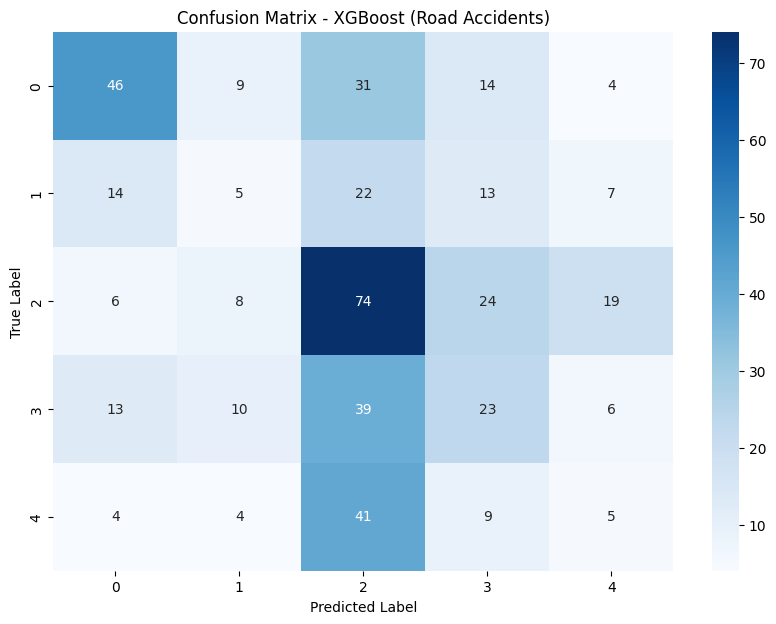

In [37]:
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost (Road Accidents)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

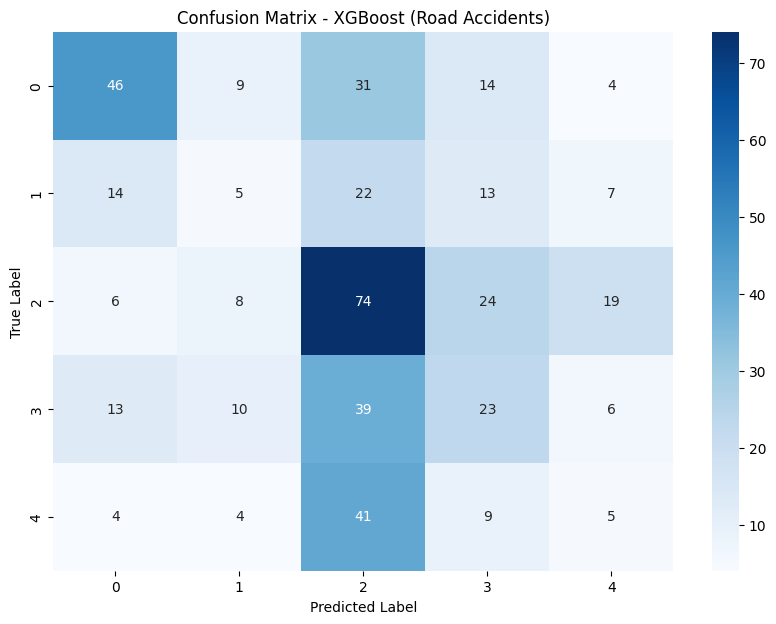

In [40]:
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost (Road Accidents)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       104
           1       0.14      0.08      0.10        61
           2       0.36      0.56      0.44       131
           3       0.28      0.25      0.26        91
           4       0.12      0.08      0.10        63

    accuracy                           0.34       450
   macro avg       0.29      0.28      0.28       450
weighted avg       0.32      0.34      0.32       450



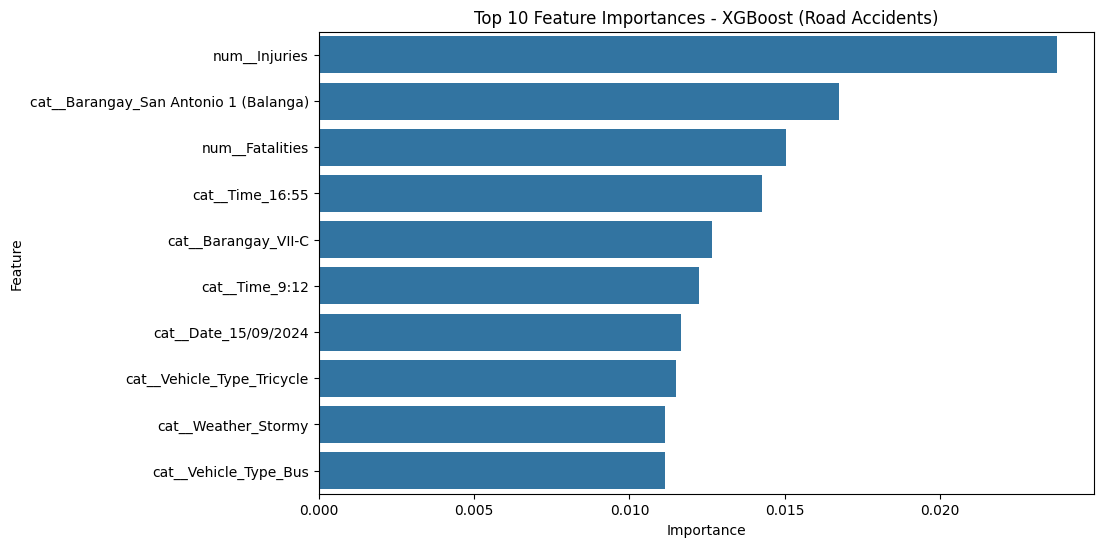

In [43]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['classifier'].feature_importances_
feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance = feat_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10))
plt.title('Top 10 Feature Importances - XGBoost (Road Accidents)')
plt.show()

In [44]:
joblib.dump(model, 'xgb_road_accident.pkl')
print("Model saved as 'xgb_road_accident.pkl'")

Model saved as 'xgb_road_accident.pkl'
